In [430]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import random

In [431]:
'''
Purpose: This class represents a single module in the song bird system, aka HVC or RA
- can be though of a single layer, with a set of neurons that are designated as the input, and a set of neurons that are designated as the output, you can technically even set only to have input neurons if you want 
'''

class SpikingModule():
    def __init__(self, inter_neuron_count, input_count, output_count, decay_rate, threshold, learning_rate, time_constant, initial_sparsity, initial_bias_range, reset_state, include_bias, state_noise, absolute_max_weight):
        self.total_neurons = inter_neuron_count + input_count + output_count
        self.neuron_states = np.zeros(self.total_neurons)
        self.connectivity_matrix = np.random.uniform(-1, 1, (self.total_neurons, self.total_neurons))
        self.input_matrix = np.random.uniform(-1, 1, (input_count))
        self.inter_neuron_count = inter_neuron_count
        self.fired_neurons_true_and_false = np.zeros(self.total_neurons, dtype=int)
        
        self.clock = 0
        self.state_noise = state_noise
        self.firing_history = []
        self.input_firing_history = []
        self.output_firing_history = []
        self.decay_rate = decay_rate
        self.learning_rate = learning_rate
        self.time_constant = time_constant
        self.threshold = threshold
        self.neuron_states_history = []
        self.reset_state = reset_state
        self.absolute_max_weight = absolute_max_weight

        self.input_freeze_mask = np.zeros_like(self.input_matrix, dtype=bool)
        self.intra_freeze_mask = np.zeros((self.total_neurons, self.total_neurons), dtype=bool)
        
        self.input_count = input_count
        self.output_count = output_count
        
        self.initialize_bias(initial_bias_range, include_bias)
        self.last_spike_time = np.zeros(self.total_neurons, dtype=int)
        self.initialize_sparsity(initial_sparsity)

    def initialize_sparsity(self, initial_sparsity):
        for i in range(self.total_neurons):
            for j in range(self.total_neurons):
                if i == j or self.intra_freeze_mask[i, j]:
                    continue
                if np.random.uniform() > initial_sparsity:
                    self.connectivity_matrix[i, j] = 0

    def initialize_bias(self, initial_bias_range, include_bias):
        if include_bias:
            self.bias_matrix = np.random.uniform(-initial_bias_range, initial_bias_range, (self.total_neurons))
            self.input_bias_matrix = np.random.uniform(-initial_bias_range, initial_bias_range, (self.input_count))
        else:
            self.bias_matrix = np.zeros((self.total_neurons))
            self.input_bias_matrix = np.zeros((self.input_count))

    def stdp(self):
        # Update weights based on STDP rule
        for i in range(len(self.connectivity_matrix)):
            for j in range(len(self.connectivity_matrix[i])):
                if i == j or self.intra_freeze_mask[i, j]:
                    continue

                last_spike_i = self.last_spike_time[i]
                last_spike_j = self.last_spike_time[j]

                if last_spike_i is None or last_spike_j is None:
                    continue
                
                # delta_t = last_spike_i - last_spike_j

                # exponentially decay the last spikes based on clock
                if self.clock > 0:
                    if last_spike_i > 0:
                        scaled_last_spike_i = last_spike_i / self.clock
                        scaled_last_spike_i = np.exp(-scaled_last_spike_i)
                    else:
                        scaled_last_spike_i = 0
                    if last_spike_j > 0:
                        scaled_last_spike_j = last_spike_j / self.clock
                        scaled_last_spike_j = np.exp(-scaled_last_spike_j)
                    else:
                        scaled_last_spike_j = 0

                    delta_t = scaled_last_spike_i - scaled_last_spike_j

                    weight_update = self.learning_rate * self.stdp_rule(delta_t)

                    self.connectivity_matrix[i, j] += weight_update

                    if self.connectivity_matrix[i, j] > self.absolute_max_weight:
                        self.connectivity_matrix[i, j] = self.absolute_max_weight

                    elif self.connectivity_matrix[i, j] < -self.absolute_max_weight:
                        self.connectivity_matrix[i, j] = -self.absolute_max_weight

    def stdp_rule(self, delta_t):
        tau = self.time_constant
        if delta_t > 0:
            return np.exp(-delta_t / tau)
        else:
            return -np.exp(delta_t / tau)

    def step(self, input):
        prev_state = self.neuron_states        
        # add the step noise
        self.neuron_states += np.random.normal(0, self.state_noise, self.neuron_states.shape)

        # process input
        weighted_input = np.multiply(self.input_matrix, input)
        weighted_input = np.add(weighted_input, self.input_bias_matrix)

        forward_updated = np.dot(self.fired_neurons_true_and_false, self.connectivity_matrix)

        forward_updated += self.bias_matrix

        self.neuron_states[:len(input)] += weighted_input
        updated_state = prev_state + forward_updated

        # multiply by the decay rate
        self.neuron_states = updated_state * self.decay_rate

        # find the neurons that have fired
        fired_neurons = np.where(self.neuron_states > self.threshold)


        cond = self.neuron_states > self.threshold
        self.fired_neurons_true_and_false = np.where(cond, 1, 0)

        # update the firing history
        self.firing_history.append(fired_neurons)

        # reset the neuron states of the fired neurons to 0
        self.neuron_states[fired_neurons] = self.reset_state

        # update last_spike_time for fired neurons
        self.last_spike_time[fired_neurons] = self.clock

        # compute the output spikes
        output_spikes_indices = np.where(self.neuron_states[-self.output_count:] > self.threshold)[0]
        output_spikes_indices += (self.total_neurons - self.output_count)

        # update the output firing history
        self.output_firing_history.append(output_spikes_indices)

        # update the weights
        self.stdp()

        self.neuron_states_history.append(np.copy(self.neuron_states))

        # increment the clock
        self.clock += 1

        return self.get_output()

    def set_input_weights(self, input_weights):
        self.input_matrix = np.array(input_weights)

    def set_internal_weights(self, internal_weights):
        self.connectivity_matrix = np.array(internal_weights)

    def get_output(self):
        return self.neuron_states[-self.output_count:]

    def get_internal_weights(self):
        return self.connectivity_matrix
    
    def get_input_weights(self):
        return self.input_matrix

    def set_internal_states(self, internal_states):
        self.neuron_states = internal_states

    def set_internal_bias(self, bias):
        self.bias_matrix = bias

    def set_weight_by_index(self, i, j, weight):
        self.connectivity_matrix[i, j] = weight

    def visualize_firing_history(self):
        # Create a figure for the firing history
        plt.figure(figsize=(10, 5))

        # Plot neuron firing history
        for i, fired_neurons in enumerate(self.firing_history):
            for neuron_idx in fired_neurons[0]:
                if neuron_idx < self.input_count:
                    color = 'gold'
                elif neuron_idx < self.input_count + self.inter_neuron_count:
                    color = 'skyblue'
                else:
                    color = 'limegreen'

                plt.plot(i, neuron_idx, marker='o', markersize=5, linestyle='None', color=color)

        plt.xlabel('Time Step')
        plt.ylabel('Neuron Index')
        plt.title('Firing History')

        # Set y-tick labels to integers
        y_ticks = np.arange(0, self.total_neurons, 1)
        plt.yticks(y_ticks)

        plt.show()

    def visualize_directed_graph(self):
        # Create a directed graph
        G = nx.DiGraph()

        # Add input, neuron, and output nodes
        input_nodes = range(self.input_count)
        inter_nodes = range(self.input_count, self.input_count + self.inter_neuron_count)
        output_nodes = range(self.input_count + self.inter_neuron_count, self.total_neurons)

        for node in input_nodes:
            G.add_node(node, node_type='input')
        for node in inter_nodes:
            G.add_node(node, node_type='inter')
        for node in output_nodes:
            G.add_node(node, node_type='output')

        # Add edges based on input, internal, and output connectivity matrices
        for i in range(self.total_neurons):
            for j in range(self.total_neurons):
                if i == j:
                    continue
                weight = self.connectivity_matrix[i, j]
                G.add_edge(i, j, weight=weight)

        # Position input nodes on the left, output nodes on the right, and inter-neuron nodes in between
        pos = {}
        for node in input_nodes:
            pos[node] = (0, (node / len(input_nodes)) * 2 - 1)
        for node in inter_nodes:
            pos[node] = (0.5, (node - len(input_nodes)) / len(inter_nodes) * 2 - 1)
        for node in output_nodes:
            pos[node] = (1, (node - self.input_count - self.inter_neuron_count) / len(output_nodes) * 2 - 1)

        # Plot the network
        fig, ax = plt.subplots()

        # Draw input, inter-neuron, and output nodes with different colors
        input_colors = ['gold'] * len(input_nodes)
        inter_colors = ['skyblue'] * len(inter_nodes)
        output_colors = ['limegreen'] * len(output_nodes)

        nx.draw_networkx_nodes(G, pos, nodelist=input_nodes, node_size=1000, node_color=input_colors, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=inter_nodes, node_size=1000, node_color=inter_colors, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=output_nodes, node_size=1000, node_color=output_colors, ax=ax)

        # Draw edges with varying thickness based on weights and different colors for inhibitory and excitatory connections
        for (u, v, d) in G.edges(data=True):
            weight = d['weight']
            edge_color = "red" if weight < 0 else "black"
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=abs(weight) * 10, edge_color=edge_color, ax=ax)

        # Draw node labels
        nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax)

        plt.show()


    def freeze_weights(self, selected_neurons, percent_to_freeze, neurons=None):
        """
        Purpose:
        - Freeze the specified percentage of weights for the selected neurons or specific neurons.
        Args:
        - selected_neurons (str): 'input', 'intra', or 'output' to choose which weights to freeze.
        - percent_to_freeze (float): The percentage of weights to freeze (between 0 and 1).
        - neurons (list of int, optional): The indices of specific neurons to freeze. If not provided, weights are frozen randomly.
        """

        if selected_neurons not in ('input', 'intra', 'output'):
            raise ValueError("selected_neurons must be one of 'input', 'intra', or 'output'.")

        if not 0 <= percent_to_freeze <= 1:
            raise ValueError("percent_to_freeze must be between 0 and 1.")

        # Choose the weight matrix based on selected_neurons
        if selected_neurons == 'input':
            weight_matrix = self.input_matrix
        if selected_neurons == 'intra':
            weight_matrix = self.connectivity_matrix

        # Create a mask to indicate frozen weights
        freeze_mask = np.zeros_like(weight_matrix, dtype=bool)

        if neurons is not None:
            if not all(isinstance(n, int) for n in neurons):
                raise ValueError("neurons must be a list of integers.")

            # Freeze all weights for the specified neurons
            for neuron_index in neurons:
                if selected_neurons == 'input':
                    freeze_mask[:, neuron_index] = True
                elif selected_neurons == 'intra':
                    freeze_mask[neuron_index, :] = True
                    freeze_mask[:, neuron_index] = True
                else:
                    freeze_mask[neuron_index, :] = True
        else:
            # Calculate the number of weights to freeze
            num_weights_to_freeze = int(np.prod(weight_matrix.shape) * percent_to_freeze)

            # Choose the indices of the weights to freeze
            freeze_indices = np.random.choice(np.arange(weight_matrix.size), num_weights_to_freeze, replace=False)
            freeze_mask.ravel()[freeze_indices] = True

        # Assign the freeze_mask to the corresponding attribute
        if selected_neurons == 'input':
            self.input_freeze_mask = freeze_mask
        elif selected_neurons == 'intra':
            self.intra_freeze_mask = freeze_mask
        else:
            self.output_freeze_mask = freeze_mask

    def freeze_specific_weight(self, i, j):
        """
        Purpose:
        - Freeze a specific weight in the connectivity matrix.
        Args:
        - i, j (int): The row and column indices of the weight to freeze.
        """

        # Check that i and j are within the valid range of indices
        num_neurons = self.connectivity_matrix.shape[0]
        if not (0 <= i < num_neurons and 0 <= j < num_neurons):
            raise ValueError("i and j must be between 0 and {}.".format(num_neurons - 1))

        self.intra_freeze_mask[i, j] = True


    def visualize_neuron_state_history(self, neuron_indices):
        # Create a figure for the neuron state history
        plt.figure(figsize=(10, 5))

        for neuron_index in neuron_indices:
            # Check if neuron_index is within the range of total_neurons
            if neuron_index < 0 or neuron_index >= self.total_neurons:
                raise ValueError("neuron_index must be within the range of total_neurons.")

            neuron_state_history = []

            # Iterate through the neuron_states_history and extract the state of the specified neuron
            for neuron_states in self.neuron_states_history:
                neuron_state = neuron_states[neuron_index]
                neuron_state_history.append(neuron_state)

            # Plot neuron state history
            plt.plot(neuron_state_history, label=f'Neuron {neuron_index}')

            # Add a red dashed line when the neuron state reaches the threshold
            for i, neuron_states in enumerate(self.neuron_states_history):
                if neuron_states[neuron_index] >= self.threshold:
                    plt.axvline(i, linestyle='--', color='red', alpha=0.5)

        plt.xlabel('Time Step')
        plt.ylabel('Neuron State')
        plt.title('Neuron State History for Selected Neurons')
        plt.legend()

        plt.show()

    def visualize_internal_connectivity_matrix(self):
        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        sns.heatmap(self.connectivity_matrix[:, :], annot=True, cmap='coolwarm', center=0, fmt='.2f')
        plt.title("Connection Weights")

        plt.show()

    def remove_connection(self, selected_neurons, neuron_indices):
        """
        Purpose:
        - Set a certain weight to zero and freeze it permanently (remove the connection).
        Args:
        - selected_neurons (str): 'input', 'intra', or 'output' to choose which weights to remove.
        - neuron_indices (tuple): A tuple containing two indices (i, j) representing the weight to remove.
        """

        if selected_neurons not in ('input', 'intra', 'output'):
            raise ValueError("selected_neurons must be one of 'input', 'intra', or 'output'.")

        if not isinstance(neuron_indices, tuple) or len(neuron_indices) != 2 or not all(isinstance(n, int) for n in neuron_indices):
            raise ValueError("neuron_indices must be a tuple of two integers.")

        i, j = neuron_indices

        # Remove the connection and freeze the weight
        if selected_neurons == 'input':
            self.input_matrix[i, j] = 0
            self.input_freeze_mask[i, j] = True
        elif selected_neurons == 'intra':
            self.connectivity_matrix[i, j] = 0
            self.intra_freeze_mask[i, j] = True
    
    def no_input_step(self):
        """
        Purpose:
        - Perform a single time step of the network without any input.
        """
        self.step(np.zeros(self.input_matrix.shape[0]))

        return self.get_output()

### Testing the HVC Ability to Learn a Song Sequence

cycle: 125
cycle: 350
cycle: 575
cycle: 800
cycle: 1025


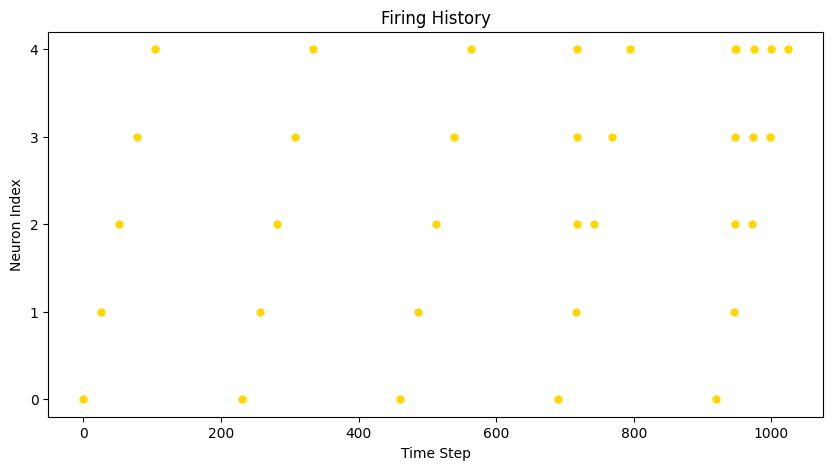

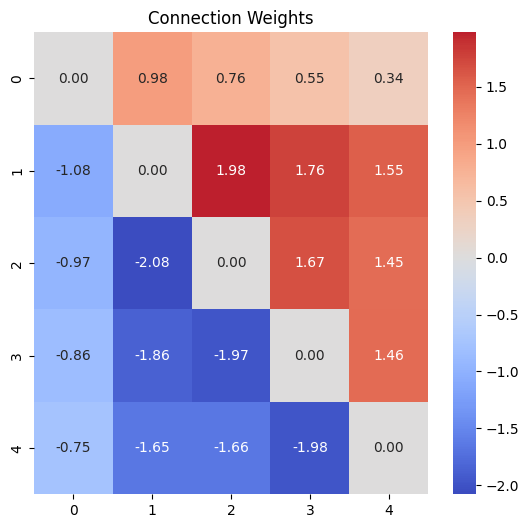

In [477]:
input_count = 5
inter_neuron_count = 0
output_count = 0

decay_rate = .9
threshold = 1
learning_rate = 0.002
time_constant = 20
inital_sparsity = .5
initial_bias_range = 0
reset_state = -.5
include_bias = False
state_noise = .005
absolute_max_weight = 5

HVC = SpikingModule(inter_neuron_count, input_count, output_count, decay_rate, threshold, learning_rate, time_constant, inital_sparsity, initial_bias_range, reset_state, include_bias=include_bias, state_noise=state_noise, absolute_max_weight=absolute_max_weight)

# steps between inputs from MMAN
between_syllables = 25
between_songs = 100

cycle_count = 1000
cycle = 0

# set input matrix all equal to one for now
HVC.set_input_weights(np.ones((input_count)))
HVC.set_internal_weights(np.zeros((input_count + inter_neuron_count + output_count, input_count + inter_neuron_count + output_count)))

# freeze feedback connections
# for i in range(input_count + inter_neuron_count + output_count):
#     for j in range(input_count + inter_neuron_count + output_count):
#         if i > j:
#             HVC.freeze_specific_weight(i,j)

while cycle < cycle_count:
    # input is a np array of length input_count with first 10 elements being 2
    input = np.zeros(input_count)
    input[0:1] = 20
    HVC.step(input)
    for i in range(between_syllables):
        HVC.no_input_step()
    cycle+=between_syllables
    input = np.zeros(input_count)
    input[1:2] = 20
    HVC.step(input)
    for i in range(between_syllables):
        HVC.no_input_step()
    cycle+=between_syllables
    input = np.zeros(input_count)
    input[2:3] = 20
    HVC.step(input)
    for i in range(between_syllables):
        HVC.no_input_step()
    cycle+=between_syllables
    input = np.zeros(input_count)
    input[3:4] = 20
    HVC.step(input)
    for i in range(between_syllables):
        HVC.no_input_step()
    cycle+=between_syllables
    input = np.zeros(input_count)
    input[4:5] = 20
    HVC.step(input)
    for i in range(between_syllables):
        HVC.no_input_step()
    cycle+=between_syllables

    print(f"cycle: {cycle}")

    for i in range(between_songs):
        HVC.no_input_step()
    cycle += between_songs

internal_weights = HVC.get_internal_weights()
input_weights = HVC.get_input_weights()

# HVC.visualize_directed_graph()
HVC.visualize_firing_history()
# HVC.visualize_neuron_state_history([0,8])
HVC.visualize_internal_connectivity_matrix()

## Check if input to one can drive the song sequence

cycle: 1
cycle: 12
cycle: 23
cycle: 34
cycle: 45
cycle: 56
cycle: 67
cycle: 78
cycle: 89
cycle: 100


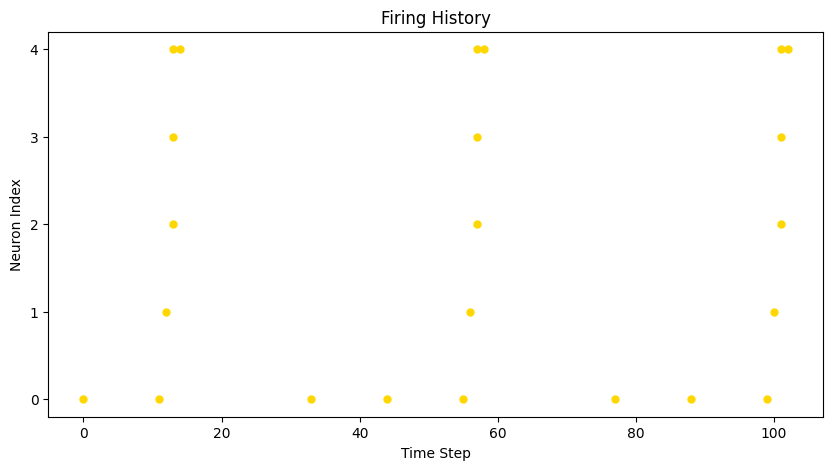

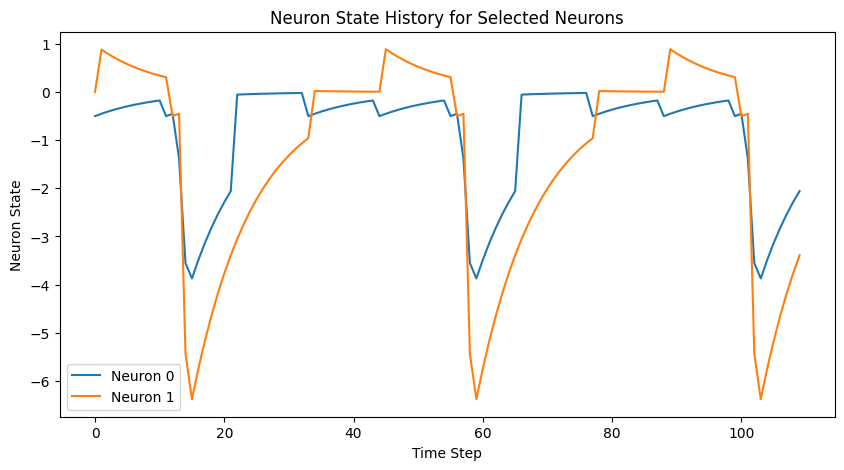

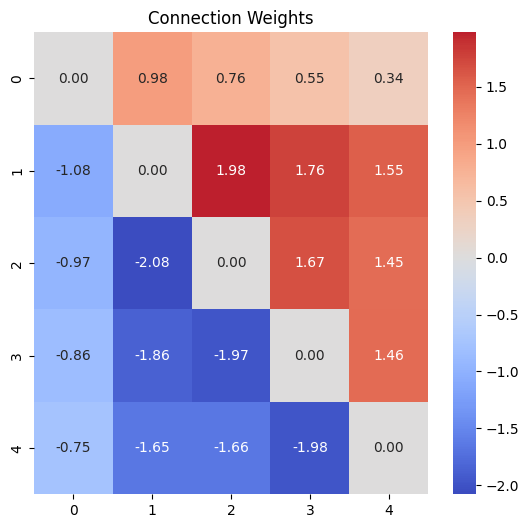

In [478]:
state_noise = 0

HVC2 = SpikingModule(inter_neuron_count, input_count, output_count, decay_rate, threshold, learning_rate, time_constant, inital_sparsity, initial_bias_range, reset_state, include_bias=include_bias, state_noise=state_noise, absolute_max_weight=absolute_max_weight)
HVC2.set_internal_weights(internal_weights)
HVC2.set_input_weights(input_weights)

# # freeze all weights
HVC2.freeze_weights('input', 1)
HVC2.freeze_weights('intra', 1)
# HVC2.set_input_weights(np.ones((input_count)))
# HVC2.set_internal_weights(np.zeros((input_count + inter_neuron_count + output_count, input_count + inter_neuron_count + output_count)))

cycle = 0
cycle_count = 100

between_songs = 10

while cycle < cycle_count:
    input = np.zeros(input_count)
    input[0:1] = 2
    HVC2.step(input)
    cycle+=1

    print(f"cycle: {cycle}")

    for i in range(between_songs):
        HVC2.no_input_step()
    cycle += between_songs


# HVC2.visualize_directed_graph()
HVC2.visualize_firing_history()
HVC2.visualize_neuron_state_history([0,1])
HVC2.visualize_internal_connectivity_matrix()

## This class is in charge of song learning

In [ ]:
class SongLearning():
    def __init__(self):
        pass

    def generate_syllable(self):
        '''Purpose:
        - Generate a syllable based on 4 random parameters 
        - The parameters are:
            - Offset
            - Frequency 
            - Phase 
            - Power 
        - Arguments:
            - None
        - Returns:
            - Syllable (np vector): vector of 4 parameters
        ''' 
        # generate a random frequency between 0 and 10 Hz
        frequency = random.randint(0, 1)
        # generate y axis offset 
        y_axis_off_set = random.randint(0, 1)
        # generate a random power between 0 and 100
        power = random.randint(0, 1)

        # generate a random color
        color = random.randint(0, 1)
        
        syllable = np.array([frequency, y_axis_off_set, power, color])    
        return syllable
    
    def generate_parent_song(self, syllable_count, syllable_length):
        '''Purpose:
        - Generate a parent song
        - Arguments:
            - syllable_count (int): The number of syllables in the song
        - Returns:
            - np array of syllables
        '''

        parent_song = np.zeros((syllable_count * syllable_length, 4)) 

        list_of_syllables = []

        for i in range(syllable_count):
            syllable = self.generate_syllable()
            list_of_syllables.append(syllable)

        for i in range(syllable_count):
            for j in range(syllable_length):
                parent_song[i * syllable_length + j] = list_of_syllables[i]

        print(parent_song.shape)
        return parent_song

    def visualize_syllable(self, syllable):
        '''Purpose:
        - Visualize a syllable
        - Arguments:
            - syllable (tuple): A tuple of 4 parameters
        - Returns:
            - None
        '''
        # unpack the syllable
        frequency, y_axis_off_set, power = syllable

        frequency *= 100
        power *= 100

        # generate a time vector
        time = np.linspace(0, 100, 1000)

        # generate the sine wave
        sine_wave = np.sin(2 * np.pi * frequency * time + y_axis_off_set) * power

        # plot the sine wave
        plt.plot(time, sine_wave)
        plt.show()

    def visualize_song(self):
        pass

    def get_parent_song(self):
        pass

    def get_syllable(self):
        pass

    def stimulate_HVC(self):
        state_noise = 0

        output_states = []

        HVC2 = SpikingModule(inter_neuron_count, input_count, output_count, decay_rate, threshold, learning_rate, time_constant, inital_sparsity, initial_bias_range, reset_state, include_bias=include_bias, state_noise=state_noise, absolute_max_weight=absolute_max_weight)
        HVC2.set_internal_weights(internal_weights)
        HVC2.set_input_weights(input_weights)

        # # freeze all weights
        HVC2.freeze_weights('input', 1)
        HVC2.freeze_weights('intra', 1)

        between_syllables = 3

        input = [1,0,0,0,0]
        output_states.append(HVC2.step(input))
        for i in range(between_syllables):
            HVC2.no_input_step()
        cycle+=between_syllables
        input = [0,1,0,0,0]
        HVC2.step(input)
        for i in range(between_syllables):
            HVC2.no_input_step()
        cycle+=between_syllables
        input = [0,0,1,0,0]
        HVC2.step(input)
        for i in range(between_syllables):
            HVC2.no_input_step()
        cycle+=between_syllables
        input = [0,0,0,1,0]
        HVC2.step(input)
        for i in range(between_syllables):
            HVC2.no_input_step()
        cycle+=between_syllables
        input = [0,0,0,0,1]
        HVC2.step(input)


    def es_optimizer(self, models, targets, population_size, epochs, sigma, learning_rate):
        '''
        Purpose (probably a one time function / not generalizable)):
        - Use an evolutionary strategy to optimize a model
        - Arguments:
            - models (list): List of models 
            - targets (list): The targets for the model, the index is the label aka element 1 is syllable 1 
            - population_size (int): The number of individuals in the population
            - epochs (int): The number of epochs to train for
            - sigma (float): The standard deviation of the noise
            - learning_rate (float): The learning rate
        '''


        


        pass

In [ ]:
song = SongLearning()
syllable = song.generate_parent_song(5,3)
